"""
Process Pavitra Preliminary Validation using 27km grid (same as WRF-CHEM)
This file works on datasets previously modified using nco in a ubuntu machine
@author: lucarojasmendoza
last modified: 2024-02-12
"""

In [14]:
#import packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box
from shapely.geometry import Point
from datetime import datetime
import os
from time import time
from cmcrameri import cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr

#This is code that needs to be improved and cannot be assumed to be accurate. There may be errors in the code
#Please do not use this code to process emissions files without having a clear understanding of what each line of
#code is exactly doing.
%run process_pavitra_emissions.py

In [4]:
#read files
#all emissions files including in_line dust
inmap_gdf=gpd.read_file('Validation_Data/Results240209/validation_year_inmap_kg_year_240106_all.shp')
#All emissions files except in-line dust
inmap_no_dust_gdf=gpd.read_file('Validation_Data/Results240209/validation_year_inmap_kg_year_240106_no_dust.shp')
#Just BC emissions
inmap_BC_gdf=gpd.read_file('Validation_Data/Results240209/validation_year_inmap_kg_year_240106_BC.shp')
#Ground base concentrations
wrfchem_gdf=gpd.read_file('Validation_Data/2017_WRF_ground_combined_ug_m3_lcc.shp')

In [6]:
inmap_gdf.head()

,BPNH4,BPNO3,BPSO4,BSOA,BTotPM25,SOA,TotalPM25,pNH4,pNO3,pPM25,pSO4,geometry
0,0.210143,0.030991,0.543797,0.127877,2.949471,0.061944,0.840046,0.061085,0.009893,0.705338,0.001785,"POLYGON ((-4401000.274 -1394439.500, -4374000...."
1,0.206178,0.035573,0.521321,0.113324,3.829908,0.062966,1.299024,0.070166,0.024794,1.136725,0.004373,"POLYGON ((-4401000.274 -1367439.500, -4374000...."
2,0.211640,0.050915,0.531599,0.102754,4.678388,0.048702,1.431146,0.073374,0.031902,1.269785,0.007383,"POLYGON ((-4401000.274 -1340439.500, -4374000...."
3,0.220607,0.063329,0.548689,0.095782,5.397246,0.064778,1.666401,0.080396,0.048204,1.461975,0.011047,"POLYGON ((-4401000.274 -1313439.500, -4374000...."
4,0.236088,0.070465,0.588801,0.086759,6.094734,0.091184,2.165053,0.104985,0.080491,1.870967,0.017426,"POLYGON ((-4401000.274 -1286439.500, -4374000...."


In [7]:
inmap_no_dust_gdf.head()

,BPNH4,BPNO3,BPSO4,BSOA,BTotPM25,SOA,TotalPM25,pNH4,pNO3,pPM25,pSO4,geometry
0,0.210143,0.030991,0.543797,0.127877,2.949471,0.061944,0.840046,0.061085,0.009893,0.705338,0.001785,"POLYGON ((-4401000.274 -1394439.500, -4374000...."
1,0.206178,0.035573,0.521321,0.113324,3.829908,0.062966,1.299024,0.070166,0.024794,1.136725,0.004373,"POLYGON ((-4401000.274 -1367439.500, -4374000...."
2,0.211640,0.050915,0.531599,0.102754,4.678388,0.048702,1.431146,0.073374,0.031902,1.269785,0.007383,"POLYGON ((-4401000.274 -1340439.500, -4374000...."
3,0.220607,0.063329,0.548689,0.095782,5.397246,0.064778,1.666401,0.080396,0.048204,1.461975,0.011047,"POLYGON ((-4401000.274 -1313439.500, -4374000...."
4,0.236088,0.070465,0.588801,0.086759,6.094734,0.091184,2.165053,0.104985,0.080491,1.870967,0.017426,"POLYGON ((-4401000.274 -1286439.500, -4374000...."


In [8]:
inmap_BC_gdf.head()

,BPNH4,BPNO3,BPSO4,BSOA,BTotPM25,SOA,TotalPM25,pNH4,pNO3,pPM25,pSO4,geometry
0,0.210143,0.030991,0.543797,0.127877,2.949471,0.0,0.055151,0.0,0.0,0.055151,0.0,"POLYGON ((-4401000.274 -1394439.500, -4374000...."
1,0.206178,0.035573,0.521321,0.113324,3.829908,0.0,0.087810,0.0,0.0,0.087810,0.0,"POLYGON ((-4401000.274 -1367439.500, -4374000...."
2,0.211640,0.050915,0.531599,0.102754,4.678388,0.0,0.098150,0.0,0.0,0.098150,0.0,"POLYGON ((-4401000.274 -1340439.500, -4374000...."
3,0.220607,0.063329,0.548689,0.095782,5.397246,0.0,0.112334,0.0,0.0,0.112334,0.0,"POLYGON ((-4401000.274 -1313439.500, -4374000...."
4,0.236088,0.070465,0.588801,0.086759,6.094734,0.0,0.144400,0.0,0.0,0.144400,0.0,"POLYGON ((-4401000.274 -1286439.500, -4374000...."


In [9]:
#Notice how the order of the polygons is not the same as the order of the points from wrf-chem output.
wrfchem_gdf.head()

,BC,Cl,Dust,Na,NH4,NO3,SO4,POA,geometry
0,0.206555,0.001524,0.232542,0.029620,0.100014,0.052835,0.355817,1.925294,POINT (-4400999.973 -1394439.483)
1,0.199994,0.001581,0.233815,0.030016,0.099652,0.054128,0.355835,1.813164,POINT (-4373999.872 -1394439.483)
2,0.200302,0.003747,0.251870,0.036022,0.096737,0.060222,0.352096,1.749321,POINT (-4347000.182 -1394439.483)
3,0.201746,0.005559,0.285908,0.041413,0.090221,0.053508,0.352054,1.654282,POINT (-4320000.081 -1394439.483)
4,0.207241,0.008492,0.325116,0.049884,0.081485,0.052440,0.350473,1.575376,POINT (-4292999.981 -1394439.483)


# Data Processing

In [5]:
#Units are ug/m3
#We need to define TotalPM25 in the wrf-chem output file
wrfchem_gdf['TotalPM25']=wrfchem_gdf['BC']+wrfchem_gdf['POA']+wrfchem_gdf['NH4']+wrfchem_gdf['SO4']+wrfchem_gdf['NO3']+wrfchem_gdf['Dust']
wrfchem_gdf.head()

,BC,Cl,Dust,Na,NH4,NO3,SO4,POA,geometry,TotalPM25
0,0.206555,0.001524,0.232542,0.029620,0.100014,0.052835,0.355817,1.925294,POINT (-4400999.973 -1394439.483),2.873057
1,0.199994,0.001581,0.233815,0.030016,0.099652,0.054128,0.355835,1.813164,POINT (-4373999.872 -1394439.483),2.756588
2,0.200302,0.003747,0.251870,0.036022,0.096737,0.060222,0.352096,1.749321,POINT (-4347000.182 -1394439.483),2.710548
3,0.201746,0.005559,0.285908,0.041413,0.090221,0.053508,0.352054,1.654282,POINT (-4320000.081 -1394439.483),2.637719
4,0.207241,0.008492,0.325116,0.049884,0.081485,0.052440,0.350473,1.575376,POINT (-4292999.981 -1394439.483),2.592131


In [6]:
#Similarly, for the inmap run we need to define a BC column and a TotalPM25 Column.
#TotalPM2.5 accounts for BC, OC (SOA), and MM (Dust?) as well as NH3 (NH4), NOx (NO3) and SO2 (SO4)
inmap_gdf['BC']=inmap_BC_gdf['pPM25']
inmap_gdf['TotalPM25']=inmap_gdf['pNH4']+inmap_gdf['pNO3']+inmap_gdf['pPM25']+inmap_gdf['pSO4']
inmap_gdf.head()

,BPNH4,BPNO3,BPSO4,BSOA,BTotPM25,SOA,TotalPM25,pNH4,pNO3,pPM25,pSO4,geometry,BC
0,0.210143,0.030991,0.543797,0.127877,2.949471,0.061944,0.778101,0.061085,0.009893,0.705338,0.001785,"POLYGON ((-4401000.274 -1394439.500, -4374000....",0.055151
1,0.206178,0.035573,0.521321,0.113324,3.829908,0.062966,1.236058,0.070166,0.024794,1.136725,0.004373,"POLYGON ((-4401000.274 -1367439.500, -4374000....",0.087810
2,0.211640,0.050915,0.531599,0.102754,4.678388,0.048702,1.382444,0.073374,0.031902,1.269785,0.007383,"POLYGON ((-4401000.274 -1340439.500, -4374000....",0.098150
3,0.220607,0.063329,0.548689,0.095782,5.397246,0.064778,1.601623,0.080396,0.048204,1.461975,0.011047,"POLYGON ((-4401000.274 -1313439.500, -4374000....",0.112334
4,0.236088,0.070465,0.588801,0.086759,6.094734,0.091184,2.073869,0.104985,0.080491,1.870967,0.017426,"POLYGON ((-4401000.274 -1286439.500, -4374000....",0.144400


# Exploration Inmap Output

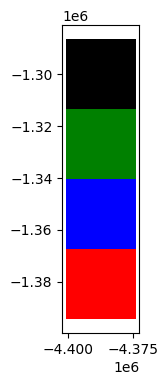

Inmap data starts from the bottom left corner and moves upwards, and then moves to the left.
WRFchem data starts from the bottom left corner and moves right, and then moves upwards.


In [29]:
# Create the plot
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the polygons from inmap_gdf dataframe
inmap_gdf.iloc[0:4].plot(ax=ax, edgecolor='white')

# Define scatter plot data
scatter_data = [
    {'index': 0, 'color': 'red'},
    {'index': 1, 'color': 'blue'},
    {'index': 2, 'color': 'green'},
    {'index': 3, 'color': 'black'}
]

# Plot the scatter points on top of the existing plot
for data_point in scatter_data:
    inmap_gdf.iloc[[data_point['index']]].plot(ax=ax, color=data_point['color'], markersize=10000)

# Show the plot
plt.show()

print('Inmap data starts from the bottom left corner and moves upwards, and then moves to the left.')
print('WRFchem data starts from the bottom left corner and moves right, and then moves upwards.')

# Exploration WRF Chem OUTPUT

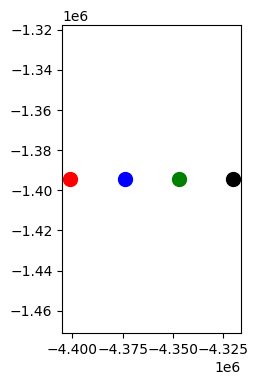

In [31]:
# Create the plot
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the polygons from inmap_gdf dataframe
wrfchem_gdf[0:4].plot(ax=ax, edgecolor='white')

# Define scatter plot data
scatter_data = [
    {'index': 0, 'color': 'red'},
    {'index': 1, 'color': 'blue'},
    {'index': 2, 'color': 'green'},
    {'index': 3, 'color': 'black'}
]

# Plot the scatter points on top of the existing plot
for data_point in scatter_data:
    wrfchem_gdf.iloc[[data_point['index']]].plot(ax=ax, color=data_point['color'], markersize=100)

# Show the plot
plt.show()

# Fix indexes (Transpose inmap results to match WRF-CHEM results)

In [7]:
#Fix indexes
#WRF_CHEM files are the default .nc file in terms of the way data is structures (bottom-left-right-upwards), but inmap is (bottom-left-upwards-left)
indexes_array = inmap_gdf.index.to_numpy()
total_elements = indexes_array.size

# Define the desired shape
desired_shape = (327, 225)
# Check if the total number of elements matches the desired shape
if total_elements == np.prod(desired_shape):
    # Reshape the array
    reshaped_array = indexes_array.reshape(desired_shape)
else:
    print("Total elements do not match the desired shape.")
    
# Transpose the array to swap rows and columns
new_array = reshaped_array.T
new_order=new_array.flatten()

# Sort inmap_gdf using the new_order and reset indexes
sorted_inmap_gdf = inmap_gdf.iloc[new_order].reset_index(drop=True)
sorted_inmap_gdf.head()

,BPNH4,BPNO3,BPSO4,BSOA,BTotPM25,SOA,TotalPM25,pNH4,pNO3,pPM25,pSO4,geometry,BC
0,0.210143,0.030991,0.543797,0.127877,2.949471,0.061944,0.778101,0.061085,0.009893,0.705338,0.001785,"POLYGON ((-4401000.274 -1394439.500, -4374000....",0.055151
1,0.212712,0.038594,0.547747,0.125648,2.901341,0.069501,0.899741,0.079177,0.014195,0.803912,0.002456,"POLYGON ((-4374000.274 -1394439.500, -4347000....",0.065316
2,0.217683,0.037863,0.588416,0.123316,2.989363,0.066037,0.930242,0.091843,0.019497,0.816265,0.002638,"POLYGON ((-4347000.274 -1394439.500, -4320000....",0.069778
3,0.223360,0.036180,0.619918,0.122955,3.149642,0.064328,1.011522,0.099781,0.023417,0.885987,0.002338,"POLYGON ((-4320000.274 -1394439.500, -4293000....",0.076715
4,0.223176,0.024275,0.661126,0.122199,3.173339,0.077353,0.947678,0.107292,0.016717,0.821587,0.002083,"POLYGON ((-4293000.274 -1394439.500, -4266000....",0.074189


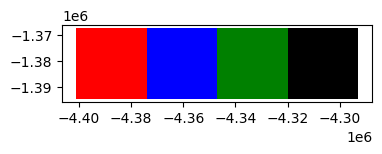

In [33]:
# Create the plot
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the polygons from inmap_gdf dataframe
sorted_inmap_gdf.iloc[0:4].plot(ax=ax, edgecolor='white')

# Define scatter plot data
scatter_data = [
    {'index': 0, 'color': 'red'},
    {'index': 1, 'color': 'blue'},
    {'index': 2, 'color': 'green'},
    {'index': 3, 'color': 'black'}
]

# Plot the scatter points on top of the existing plot
for data_point in scatter_data:
    sorted_inmap_gdf.iloc[[data_point['index']]].plot(ax=ax, color=data_point['color'], markersize=10000)

# Show the plot
plt.show()

# Check overlap Point - Polygon

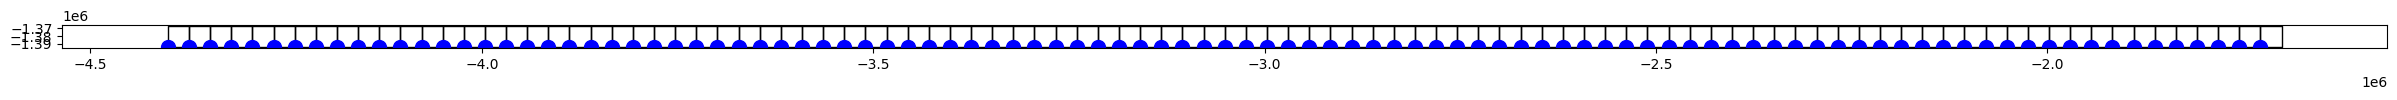

In [50]:
# Create the plot
fig, ax = plt.subplots(figsize=(30,10))

# Define scatter plot data
scatter_data = [
    {'index': i, 'color': 'blue'} for i in range(100)
]

# Plot the scatter points on top of the existing plot
for data_point in scatter_data:
    sorted_inmap_gdf.iloc[[data_point['index']]].plot(ax=ax, markersize=10000, facecolor='none', edgecolor='black')

for data_point in scatter_data:
    wrfchem_gdf.iloc[[data_point['index']]].plot(ax=ax, color=data_point['color'], markersize=100)

# Show the plot
plt.show()


# Regroud inmap output to wrf-chem output

In [153]:
#Work in progress. If inmap resolution differs from wrf-chem output, the output will need to be reshaped before statistical analysis is performed

# Combine Information in just one file

In [8]:
sorted_inmap_gdf['wrf_pNH4']=wrfchem_gdf['NH4']
sorted_inmap_gdf['wrf_pNO3']=wrfchem_gdf['NO3']
sorted_inmap_gdf['wrf_pSO4']=wrfchem_gdf['SO4']
sorted_inmap_gdf['wrf_TotalPM25']=wrfchem_gdf['TotalPM25']
sorted_inmap_gdf['wrf_BC']=wrfchem_gdf['BC']

sorted_inmap_gdf.loc[:,'Bias_pNH4']=sorted_inmap_gdf['pNH4']-sorted_inmap_gdf['wrf_pNH4']
sorted_inmap_gdf.loc[:,'Bias_pNO3']=sorted_inmap_gdf['pNO3']-sorted_inmap_gdf['wrf_pNO3']
sorted_inmap_gdf.loc[:,'Bias_pSO4']=sorted_inmap_gdf['pSO4']-sorted_inmap_gdf['wrf_pSO4']
sorted_inmap_gdf.loc[:,'Bias_TotalPM25']=sorted_inmap_gdf['TotalPM25']-sorted_inmap_gdf['wrf_TotalPM25']
sorted_inmap_gdf.loc[:,'Bias_BC']=sorted_inmap_gdf['BC']-sorted_inmap_gdf['wrf_BC']
sorted_inmap_gdf.head()

,BPNH4,BPNO3,BPSO4,BSOA,BTotPM25,SOA,TotalPM25,pNH4,pNO3,pPM25,...,wrf_pNH4,wrf_pNO3,wrf_pSO4,wrf_TotalPM25,wrf_BC,Bias_pNH4,Bias_pNO3,Bias_pSO4,Bias_TotalPM25,Bias_BC
0,0.210143,0.030991,0.543797,0.127877,2.949471,0.061944,0.778101,0.061085,0.009893,0.705338,...,0.100014,0.052835,0.355817,2.873057,0.206555,-0.038929,-0.042942,-0.354032,-2.094956,-0.151404
1,0.212712,0.038594,0.547747,0.125648,2.901341,0.069501,0.899741,0.079177,0.014195,0.803912,...,0.099652,0.054128,0.355835,2.756588,0.199994,-0.020475,-0.039933,-0.353379,-1.856847,-0.134678
2,0.217683,0.037863,0.588416,0.123316,2.989363,0.066037,0.930242,0.091843,0.019497,0.816265,...,0.096737,0.060222,0.352096,2.710548,0.200302,-0.004894,-0.040725,-0.349458,-1.780306,-0.130524
3,0.223360,0.036180,0.619918,0.122955,3.149642,0.064328,1.011522,0.099781,0.023417,0.885987,...,0.090221,0.053508,0.352054,2.637719,0.201746,0.009560,-0.030091,-0.349716,-1.626197,-0.125031
4,0.223176,0.024275,0.661126,0.122199,3.173339,0.077353,0.947678,0.107292,0.016717,0.821587,...,0.081485,0.052440,0.350473,2.592131,0.207241,0.025807,-0.035723,-0.348390,-1.644453,-0.133052


# Clip dataframe 

In [9]:
# Define the coordinates for the bounding box
minx, miny, maxx, mayy = -2300000.0, -205000.0, 2200000.0, 4670000.0

# Use the cx indexer to clip the GeoDataFrame to the bounding box
sorted_inmap_gdf = sorted_inmap_gdf.cx[minx:maxx, miny:mayy]

In [10]:
import numpy as np
import pandas as pd

# Create a function to calculate statistics for a specific county and chemical
def calculate_statistics(df_temp, inmap_column_name, wrf_column_name):
    
    n = len(df_temp)
    mean_wrf = np.mean(df_temp[wrf_column_name])
    mean_inmap = np.mean(df_temp[inmap_column_name])
    stdev_wrf = np.std(df_temp[wrf_column_name])
    stdev_inmap = np.std(df_temp[inmap_column_name])
    mb = np.mean(df_temp[inmap_column_name] - df_temp[wrf_column_name])
    me = np.mean(np.abs(df_temp[inmap_column_name] - df_temp[wrf_column_name]))    
    rmse = np.sqrt(np.mean(np.square(df_temp[inmap_column_name] - df_temp[wrf_column_name])))
    fb = 200 * np.mean((df_temp[inmap_column_name] - df_temp[wrf_column_name]) / (df_temp[inmap_column_name] + df_temp[wrf_column_name]))
    fe = 200 * np.mean(np.abs(df_temp[inmap_column_name] - df_temp[wrf_column_name]) / (df_temp[inmap_column_name] + df_temp[wrf_column_name]))
    nmb = 100 * (np.sum(df_temp[inmap_column_name] - df_temp[wrf_column_name]) / np.sum(df_temp[wrf_column_name]))
    nme = 100 * (np.sum(np.abs(df_temp[inmap_column_name] - df_temp[wrf_column_name])) / np.sum(df_temp[wrf_column_name]))
    mnb = 100 * np.mean((df_temp[inmap_column_name] - df_temp[wrf_column_name]) / df_temp[wrf_column_name])
    mne = 100 * np.mean(np.abs((df_temp[inmap_column_name] - df_temp[wrf_column_name]) / df_temp[wrf_column_name]))
    r2 = np.corrcoef(df_temp[wrf_column_name], df_temp[inmap_column_name])[0, 1] ** 2
    
    return {
        'Chemical': inmap_column_name,
        'n': n,
        'Mean_wrf': mean_wrf,
        'Mean_inmap': mean_inmap,
        'Stdev_wrf': stdev_wrf,
        'Stdev_inmap': stdev_inmap,
        'MB': mb,
        'ME': me,
        'RMSE': rmse,
        'FB %': fb,
        'FE %': fe,
        'NMB %': nmb,
        'NME %': nme,
        'MNB %': mnb,
        'MNE %': mne,
        'r2': r2,
    }

# Define the column name pairs
column_name_pairs = [ {"inmap_column_name": "BC", "wrf_column_name": "wrf_BC"},
                      {"inmap_column_name": "TotalPM25", "wrf_column_name": "wrf_TotalPM25"},
                      {"inmap_column_name": "pNH4", "wrf_column_name": "wrf_pNH4"},
                      {"inmap_column_name": "pSO4", "wrf_column_name": "wrf_pSO4"},
                      {"inmap_column_name": "pNO3", "wrf_column_name": "wrf_pNO3"}]

# Create an empty list to store the results
summary = []

# Loop through the column name pairs
for pair in column_name_pairs:
    stats = calculate_statistics(sorted_inmap_gdf, pair["inmap_column_name"], pair["wrf_column_name"])
    summary.append(stats)

# Create a DataFrame from the summary list
df_stats = pd.DataFrame(summary)
df_stats = df_stats.round(2)
df_stats

,Chemical,n,Mean_wrf,Mean_inmap,Stdev_wrf,Stdev_inmap,MB,ME,RMSE,FB %,FE %,NMB %,NME %,MNB %,MNE %,r2
0,BC,30408,0.64,0.33,1.20,0.54,-0.31,0.34,0.85,-80.28,90.67,-48.27,53.34,-45.19,61.74,0.73
1,TotalPM25,30408,15.62,25.07,16.79,39.05,9.46,13.55,31.43,-8.13,71.42,60.55,86.79,34.35,84.35,0.48
2,pNH4,30408,1.03,1.73,1.41,2.64,0.70,0.92,1.61,-10.13,86.20,68.03,89.27,55.10,113.59,0.85
3,pSO4,30408,1.89,3.30,1.35,4.24,1.40,1.93,3.56,-9.29,76.00,74.20,101.79,36.92,89.72,0.64
4,pNO3,30408,1.62,1.84,3.48,3.10,0.22,0.84,1.70,2.61,78.64,13.39,52.06,83.83,131.26,0.76


• Performance Criteria for the USA against monitoring sides
• FB ≤ ±60% • FE ≤ 75% 

# Side by side plots for pollutants plotting at 99%

In [21]:
borders_path = 'Pavitra_IITB/INDIA_BOUNDARY/INDIA_BOUNDARY.shp'
#Re_projects to this one
source_crs = "+proj=merc +units=m +a=6370000.0 +b=6370000. +lon_0=80.0 +lat_ts=15.0"
#re-assigns to this one
assign_crs = "+proj=lcc +lat_1=33.000000 +lat_2=45.000000 +lat_0=40.000000 +lon_0=-97.000000 +x_0=0 +y_0=0 +a=6370997.000000 +b=6370997.000000 +to_meter=1"

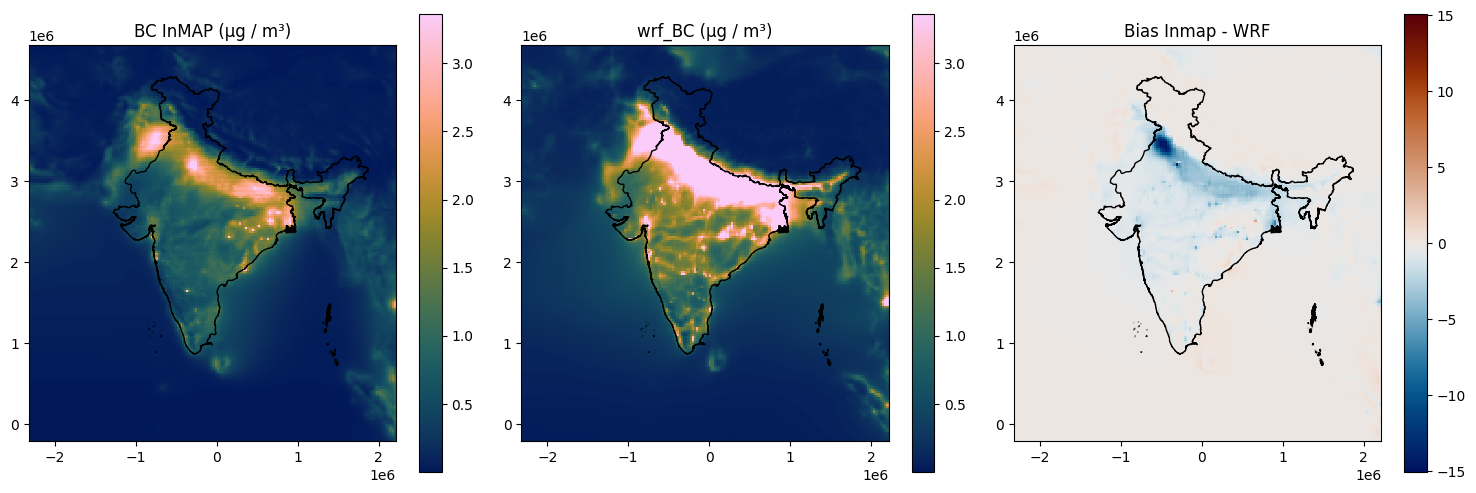

In [23]:
inmap_column_name = "BC"
wrf_column_name = "wrf_BC"
bias_column_name = 'Bias_BC'
percentile =99
plot_inmap_wrf_bias(sorted_inmap_gdf, borders_path, source_crs, inmap_column_name, wrf_column_name, bias_column_name, percentile, assign_crs=assign_crs)

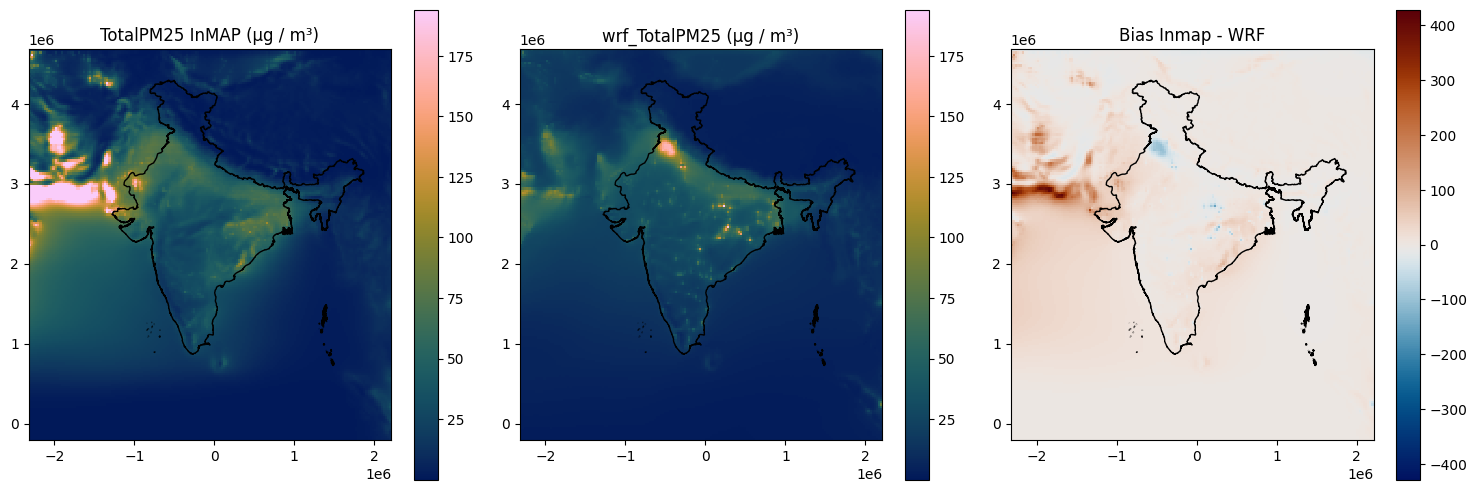

In [24]:
inmap_column_name = "TotalPM25"
wrf_column_name = "wrf_TotalPM25"
bias_column_name = 'Bias_TotalPM25'
percentile =99
plot_inmap_wrf_bias(sorted_inmap_gdf, borders_path, source_crs, inmap_column_name, wrf_column_name, bias_column_name, percentile, assign_crs=assign_crs)

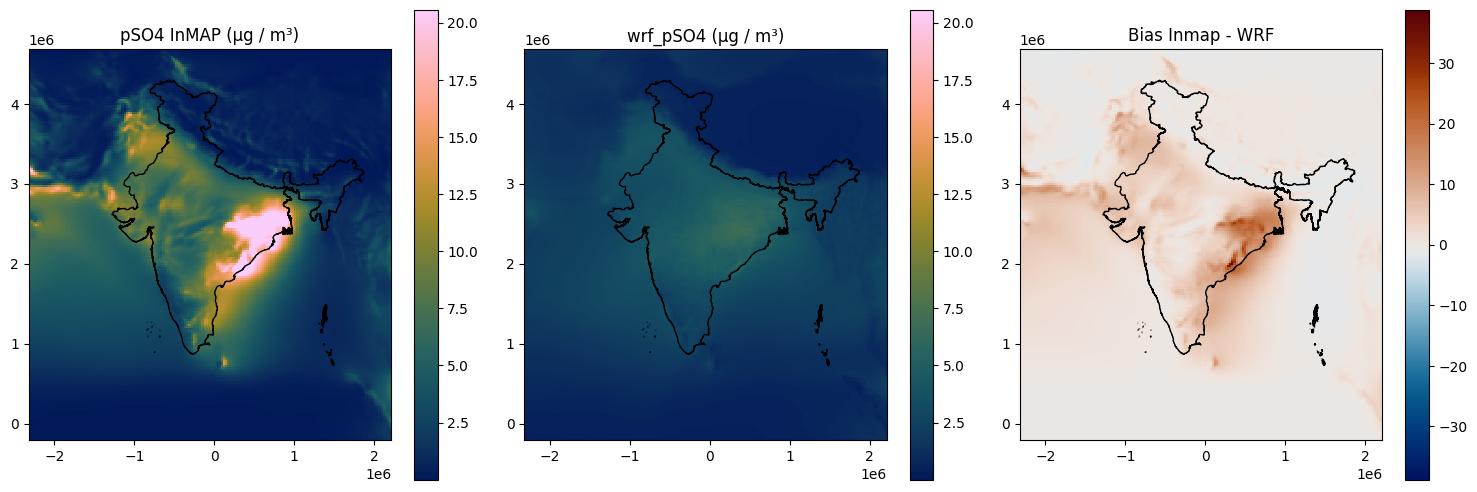

In [25]:
inmap_column_name = "pSO4"
wrf_column_name = "wrf_pSO4"
bias_column_name= 'Bias_pSO4'
percentile =99
plot_inmap_wrf_bias(sorted_inmap_gdf, borders_path, source_crs, inmap_column_name, wrf_column_name, bias_column_name, percentile, assign_crs=assign_crs)
# it tends to have higher concentrations in summer because photochemical reactions but in this case we are always overpredicting? is it because the variations in emissions over the months? or is it more about a dispersion issue with the model?. It is being quickly converted to SO4 instead of being dispersed.

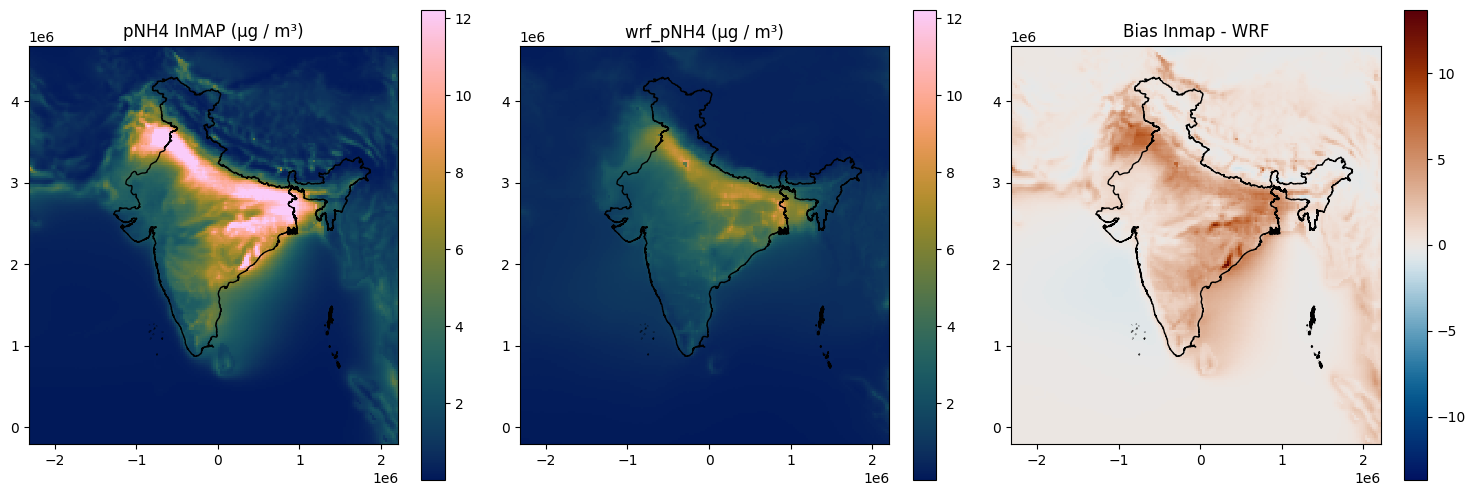

In [26]:
inmap_column_name = "pNH4"
wrf_column_name = "wrf_pNH4"
bias_column_name = 'Bias_pNH4'
percentile =99
plot_inmap_wrf_bias(sorted_inmap_gdf, borders_path, source_crs, inmap_column_name, wrf_column_name, bias_column_name, percentile, assign_crs=assign_crs)

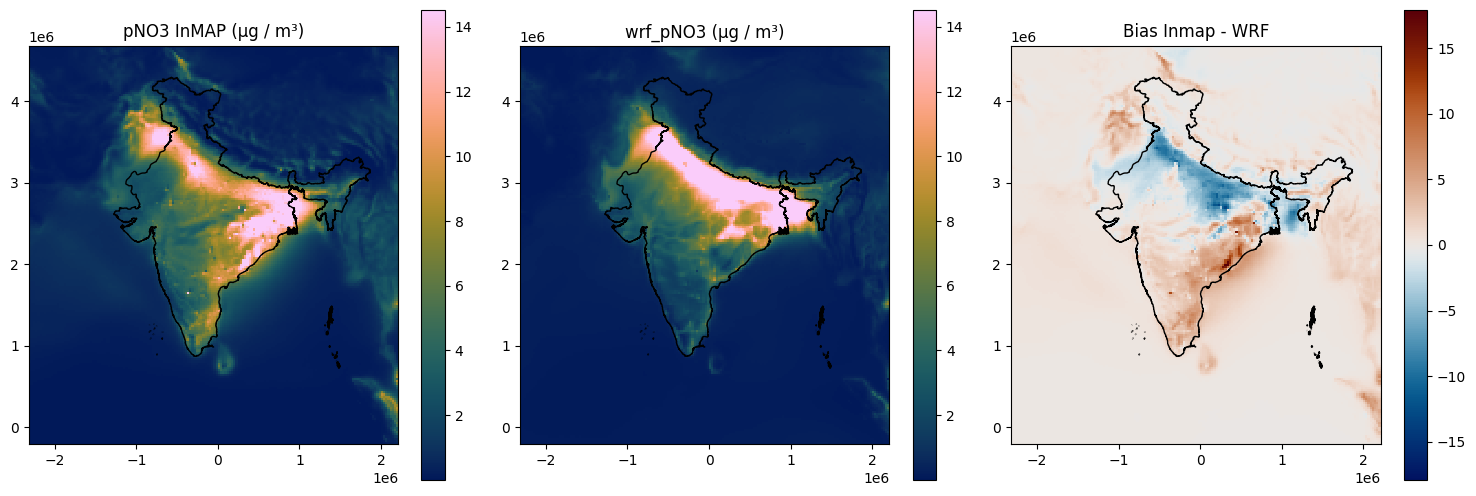

In [27]:
inmap_column_name = "pNO3"
wrf_column_name = "wrf_pNO3"
bias_column_name = 'Bias_pNO3'
percentile =99
plot_inmap_wrf_bias(sorted_inmap_gdf, borders_path, source_crs, inmap_column_name, wrf_column_name, bias_column_name, percentile, assign_crs=assign_crs)
#NO3(s) prefers low temperatures in winter. But we are underpredicting on average during the year. We should take a look at the montly distributions

# Distributions (Choose polutant)

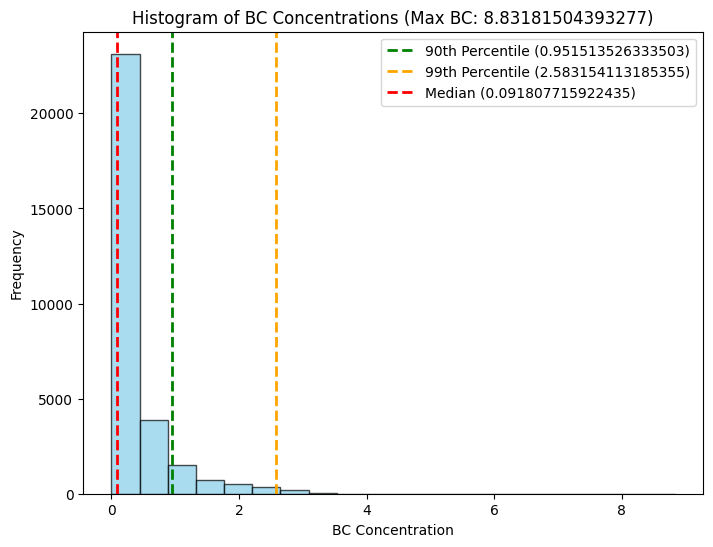

In [54]:
# Access the 'BC' column from sorted_inmap_gdf
bc_data = sorted_inmap_gdf['BC']
max_bc_value=bc_data.max()

# Calculate the 90th, 99th percentile, and median
percentile_90 = np.percentile(bc_data, 90)
percentile_99 = np.percentile(bc_data, 99)
median = np.median(bc_data)

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(bc_data, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('BC Concentration')
plt.ylabel('Frequency')
plt.title(f'Histogram of BC Concentrations (Max BC: {max_bc_value})')

# Add lines for the 90th percentile, 99th percentile, and median
plt.axvline(x=percentile_90, color='green', linestyle='dashed', linewidth=2, label=f'90th Percentile ({percentile_90})')
plt.axvline(x=percentile_99, color='orange', linestyle='dashed', linewidth=2, label=f'99th Percentile ({percentile_99})')
plt.axvline(x=median, color='red', linestyle='dashed', linewidth=2, label=f'Median ({median})')

# Add a legend
plt.legend()

# Show the histogram
plt.show()


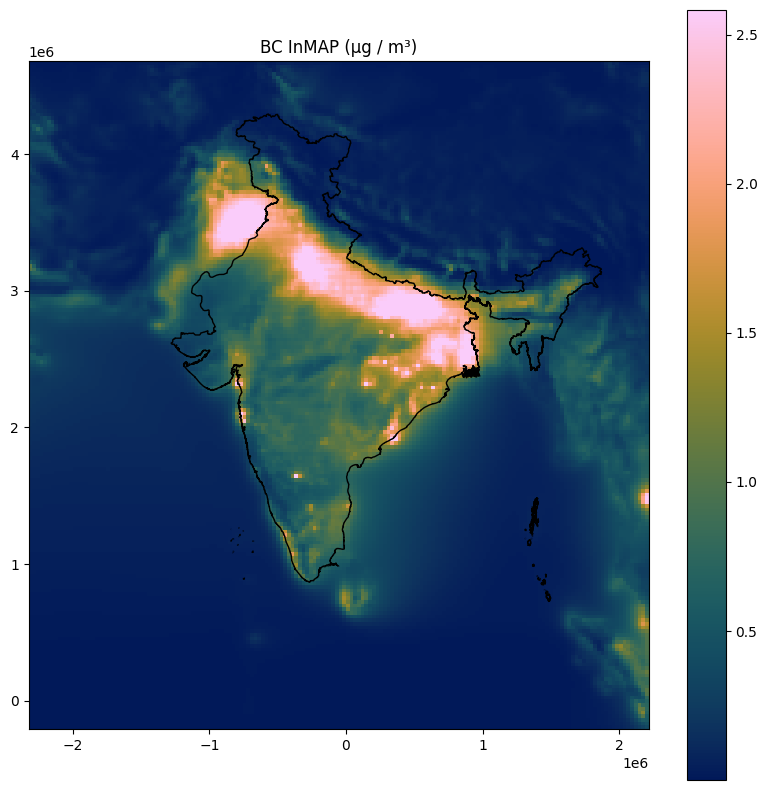

In [29]:
# Read the border shapefile and convert it to the target CRS
border_gdf = gpd.read_file(borders_path)
border_gdf = border_gdf.to_crs(source_crs)

# Specify the column names
inmap_column_name = "BC"

# Read your GeoDataFrame (gdf) here

gdf=sorted_inmap_gdf

# Define the color scale range based on the minimum and maximum values of the specified column
vmin = gdf[inmap_column_name].min()
vmax = np.percentile(gdf['BC'], 99)


# Create a single subplot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the specified column from gdf with the 'batlow' colormap
gdf.plot(column=inmap_column_name, cmap=cm.batlow, legend=True, ax=ax, vmin=vmin, vmax=vmax)
ax.set_title(f'{inmap_column_name} InMAP (μg / m\u00B3)')

# Plot the country borders on the same subplot
border_gdf.plot(ax=ax, edgecolor='black', color='none')

# Set x and y limits based on point values
x_min, y_min, x_max, y_max = gdf.geometry.total_bounds
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Show the plot
plt.show()


# How well is the model in relation to a 1-1, 1:2 and 1:3 line?

In [30]:
def plot_hexbin_with_lines(dataframe, x_variable, y_variable, gridsize=20):
    # Extract x and y data from the DataFrame
    x = dataframe[x_variable]
    y = dataframe[y_variable]

    # Create the hexbin plot
    plt.figure(figsize=(5, 4))
    hb = plt.hexbin(x, y, gridsize=gridsize, cmap=cm.imola, mincnt=1)
    plt.colorbar(label='Count in Bin')
    plt.xlabel(f'{x_variable} (μg/m\u00B3)')
    plt.ylabel(f'{y_variable} (μg/m\u00B3)')
    plt.title(f'{x_variable} vs {y_variable} (μg/m\u00B3)')
    plt.grid(True)

    # Calculate max values for x and y
    max_value = max(max(x), max(y))
    one_to_one = [0, max_value]
    one_to_two = [0, max_value/2]
    one_to_three = [0, max_value/3]

    # Plot the 1:1 line
    plt.plot(one_to_one, one_to_one, color='red', linestyle='-', label='1:1 Line')
    # Plot the 1:2 lines
    plt.plot(one_to_two, one_to_one, color='red', linestyle='--', label='1:2 Line')
    plt.plot(one_to_one, one_to_two, color='red', linestyle='--')
    # Plot the 1:3 lines
    plt.plot(one_to_three, one_to_one, color='red', linestyle=':', label='1:3 Line')
    plt.plot(one_to_one, one_to_three, color='red', linestyle=':')

    plt.legend()
    plt.tight_layout()
    plt.show()

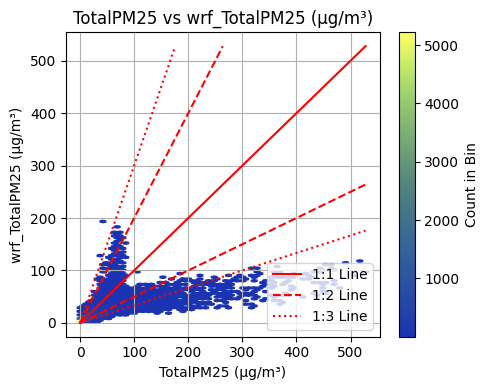

In [31]:
plot_hexbin_with_lines(sorted_inmap_gdf, 'TotalPM25', 'wrf_TotalPM25', gridsize=50)

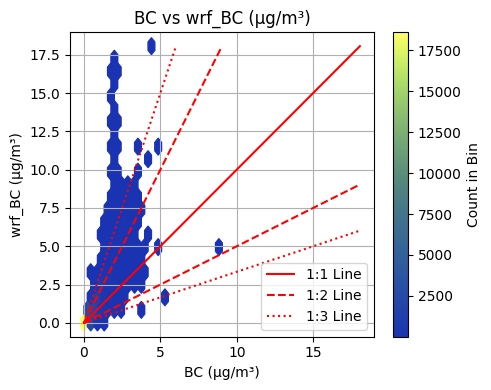

In [33]:
plot_hexbin_with_lines(sorted_inmap_gdf, 'BC', 'wrf_BC', gridsize=20)

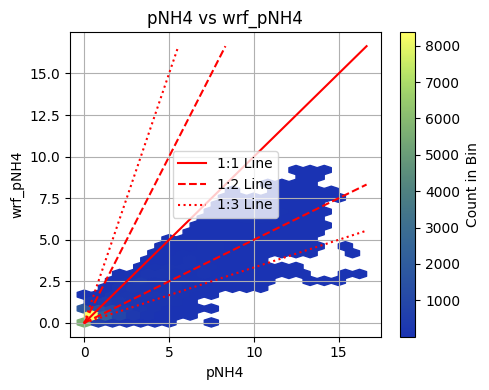

In [115]:
plot_hexbin_with_lines(sorted_inmap_gdf, 'pNH4', 'wrf_pNH4', gridsize=20)

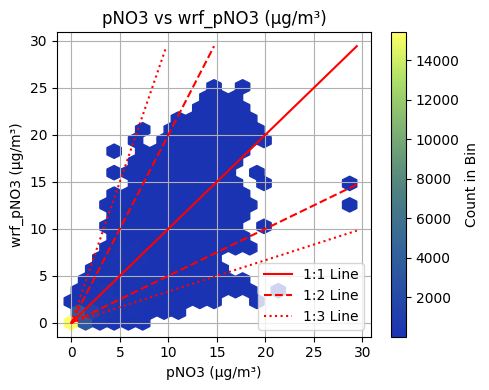

In [151]:
plot_hexbin_with_lines(sorted_inmap_gdf, 'pNO3', 'wrf_pNO3', gridsize=20)

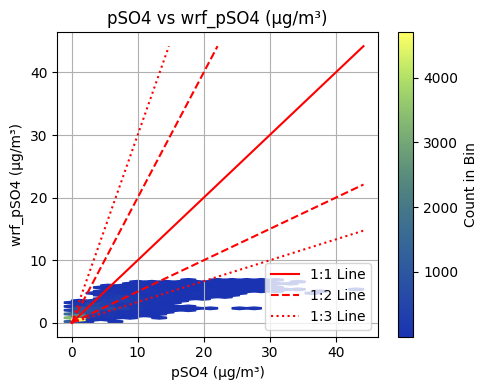

In [152]:
plot_hexbin_with_lines(sorted_inmap_gdf, 'pSO4', 'wrf_pSO4', gridsize=20)

# Population Weighted Comparison

In [ ]:
1) modify population file